# Mixture of Experts on Convolutional Neural Network

Mixture of experts is a ensemble model of neural networks which consists of expert neural networks and gating networks. The expert model is a series of neural network that is specialized in a certain inference, such as classifying within artificial objects or within natural objects. The gating network is a discriminator network that decides which expert, or expers, to use for a certain input data, with importance of each expert.<br>
The mixture of experts can take one gating network, if only deciding an importance of experts, or multiple gating networks, to probabilistically split decision phases to hierarchical order, just like decision tree diagram.<br>
The expert models are pretrained to do only feed-forward inference in the mixture of experts model.<br>
Training phase of the mixture of experts is to train the gating networks to improve decision making of which experts to use with weighted degree of importance of each experts.

This notebook shows a way to use mixture of experts model with deep learning. The objective is to classify images, using Cifar10 and convolution neural netwok. The mixture of experts model takes hierarchical multiple gating networks, to first decide if the input image is artificial object or natural object. Then the next gating network decides importance of each expert models. There are three expert models:<br>
1. basic VGG, which is trained to classify all 10 classes
2. artificial expert VGG, which is trained only to classify artificial objects, that have a label in 0, 1, 8 and 9
3. natural expert VGG, which is trained only to classify natural objects, that have a label in 2, 3, 4, 5, 6 and 7
<br><br>
### The overview of the mixture of experts model

![0.png](0.png)

The first gating network, that decides which way to take, artificial or natural, is a pretrained VGG neural network, to classify the input data.<br>
The second gating network layer, consists of two gating networks, decides the importance of each experts. The artificial gating network flows classification job to artificial expert VGG and base VGG, only activated when the first gating network decided the input data is an artificial object. The natural gating network flows classification job to natural expert VGG and base VGG, only the first gating netword decided as a natural object.<br>
The classification output is a sum of softmax of expert VGG and base VGG, with importance from previous gating network multiplied.

The notebook uses Keras with Tensorflow backend to implement the mixture of network model for classifying Cifar10.<br>
The Cifar10 consists of 10 classes of images, with label of each class representing the following.<br><br>
0 airplane<br>
1 automobile<br>
2 bird<br>
3 cat<br>
4 deer<br>
5 dog<br>
6 frog<br>
7 horse<br>
8 ship<br>
9 truck<br>

## Prerequisite

In [220]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import concatenate, Lambda, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import keras.backend as K
from keras.datasets import cifar10
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pydot
from IPython.display import SVG

In [82]:
# parameters
batch_size = 50
orig_classes = 10
gate0_classes = 2
epochs = 100

In [43]:
# get the newest model file within a directory
def getNewestModel(model, dirname):
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model

## Prepare datasets

In [25]:
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
50000 train samples
10000 test samples


In [26]:
# prepare x dataset
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [27]:
# Convert class vectors to binary class matrices.
y_train0 = keras.utils.to_categorical(y_train, orig_classes)
y_test0 = keras.utils.to_categorical(y_test, orig_classes)

print("y train0:{0}\ny test0:{1}".format(y_train0.shape, y_test0.shape))

y train0:(50000, 10)
y test0:(10000, 10)


## Define networks

In [28]:
# input layer
cifarInput = Input(shape=(x_train.shape[1:]), name="input")

In [33]:
# simple VGG-like model for the first and gating neural networks
def simpleVGG(cifarInput, num_classes, name="vgg"):
    name = [name+str(i) for i in range(12)]
    
    # convolution and max pooling layers
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[0])(cifarInput)
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[1])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[2])(vgg)
    vgg = Dropout(0.25, name=name[3])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[4])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[5])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[6])(vgg)
    vgg = Dropout(0.25, name=name[7])(vgg)

    # classification layers
    vgg = Flatten(name=name[8])(vgg)
    vgg = Dense(512, activation='relu', name=name[9])(vgg)
    vgg = Dropout(0.5, name=name[10])(vgg)
    vgg = Dense(num_classes, activation='softmax', name=name[11])(vgg)
    return vgg

In [34]:
# fat and long VGG-like model for expert neural networks
def fatVGG(cifarInput, num_classes, name="vgg"):
    name = [name+str(i) for i in range(17)]
    
    # convolution and max pooling layers
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[0])(cifarInput)
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[1])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[2])(vgg)
    vgg = Dropout(0.25, name=name[3])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[4])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[5])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[6])(vgg)
    vgg = Dropout(0.25, name=name[7])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[8])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[9])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[10])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[11])(vgg)
    vgg = Dropout(0.25, name=name[12])(vgg)

    # classification layers
    vgg = Flatten(name=name[13])(vgg)
    vgg = Dense(512, activation='relu', name=name[14])(vgg)
    vgg = Dropout(0.5, name=name[15])(vgg)
    vgg = Dense(num_classes, activation='softmax', name=name[16])(vgg)
    return vgg

In [80]:
# first gating network, to decide artificial or natural object
gate0VGG = simpleVGG(cifarInput, gate0_classes, "gate0")
gate0Model = Model(cifarInput, gate0VGG)

# base VGG
baseVGG = simpleVGG(cifarInput, orig_classes, "base")
baseModel = Model(cifarInput, baseVGG)

# artificial expert VGG
artificialVGG = fatVGG(cifarInput, orig_classes, "artificial")
artificialModel = Model(cifarInput, artificialVGG)

# natural expert VGG
naturalVGG = fatVGG(cifarInput, orig_classes, "natural")
naturalModel = Model(cifarInput, naturalVGG)

## Train networks

### Base VGG

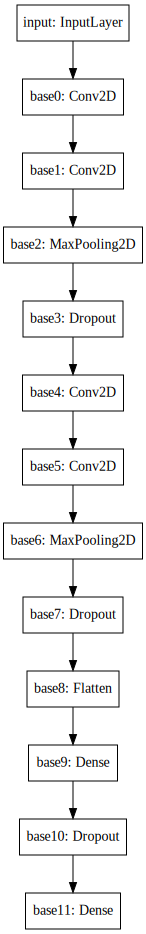

In [222]:
# show the base model diagram
plot_model(baseModel, to_file='baseModel.png')
SVG(model_to_dot(baseModel).create(prog='dot', format='svg'))

![baseModel.png](./baseModel.png)

In [85]:
# compile
baseModel.compile(loss='categorical_crossentropy',
                   optimizer=Adam(),
                   metrics=['accuracy'])

In [47]:
# make saving directory for checkpoints
baseSaveDir = "./baseCifar10/"
if not os.path.isdir(baseSaveDir):
    os.makedirs(baseSaveDir)
    
# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = os.path.join(baseSaveDir, 'Cifar10_.{epoch:02d}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# load the newest model data from the directory if exists
baseModel = getNewestModel(baseModel, baseSaveDir)

In [48]:
# train
baseModel.fit(x_train, y_train0,
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_test, y_test0),
               callbacks=[es_cb,cp_cb])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 27s 542us/step - loss: 1.4949 - acc: 0.4537 - val_loss: 1.1673 - val_acc: 0.5882
Epoch 2/100
50000/50000 [==============================] - 22s 435us/step - loss: 1.0804 - acc: 0.6154 - val_loss: 0.9021 - val_acc: 0.6827
Epoch 3/100
50000/50000 [==============================] - 22s 437us/step - loss: 0.9130 - acc: 0.6788 - val_loss: 0.8071 - val_acc: 0.7172
Epoch 4/100
50000/50000 [==============================] - 21s 429us/step - loss: 0.8146 - acc: 0.7140 - val_loss: 0.7758 - val_acc: 0.7285
Epoch 5/100
50000/50000 [==============================] - 21s 427us/step - loss: 0.7431 - acc: 0.7410 - val_loss: 0.7185 - val_acc: 0.7492
Epoch 6/100
50000/50000 [==============================] - 22s 435us/step - loss: 0.6849 - acc: 0.7591 - val_loss: 0.6998 - val_acc: 0.7586
Epoch 7/100
50000/50000 [==============================] - 22s 432us/step - loss: 0.6378 - acc: 0.7758 - val_l

In [87]:
# evaluate
baseModel = getNewestModel(baseModel, baseSaveDir)
baseScore = baseModel.evaluate(x_test, y_test0)
print(baseScore)

10000/10000 [==============================] - 2s 192us/step
[0.66931399374008183, 0.76929999999999998]


## Prepare data for the first gating network and train

The first gating network decides which way to take: artificial or natural.<br>
In order to decide, the gating network classifies if the input data is artificial object or natural object, by simply running VGG inference.

In [52]:
# prepare dataset for the first gating network
# generate target labels with 0 or 1, with 0 for artificial object and 1 for natural object
y_trainG0 = np.array([0 if i in [0,1,8,9] else 1 for i in y_train])
y_testG0 = np.array([0 if i in [0,1,8,9] else 1 for i in y_test])
y_trainG0 = keras.utils.to_categorical(y_trainG0, 2)
y_testG0 = keras.utils.to_categorical(y_testG0, 2)

print("y trainG0:{0}\ny testG0:{1}".format(y_trainG0.shape, y_testG0.shape))

y trainG0:(50000, 2)
y testG0:(10000, 2)


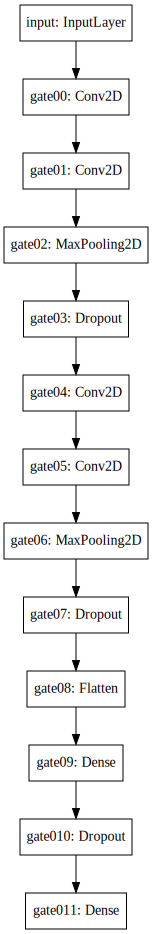

In [223]:
# show the first gating network diagram
plot_model(gate0Model, to_file='gate0Model.png')
SVG(model_to_dot(gate0Model).create(prog='dot', format='svg'))

![gate0Model.png](./gate0Model.png)

In [88]:
# compile
gate0Model.compile(loss='categorical_crossentropy',
                   optimizer=Adam(),
                   metrics=['accuracy'])

In [58]:
# make saving directory for check point
gate0SaveDir = "./gate0Cifar10/"
if not os.path.isdir(gate0SaveDir):
    os.makedirs(gate0SaveDir)
    
# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = os.path.join(gate0SaveDir, 'Cifar10_.{epoch:02d}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# load the newest model data from the directory if exists
gate0Model = getNewestModel(gate0Model, gate0SaveDir)

In [59]:
# train
gate0Model.fit(x_train, y_trainG0,
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_test, y_testG0),
               callbacks=[es_cb,cp_cb])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 22s 445us/step - loss: 0.2822 - acc: 0.8843 - val_loss: 0.1940 - val_acc: 0.9212
Epoch 2/100
50000/50000 [==============================] - 21s 429us/step - loss: 0.1992 - acc: 0.9213 - val_loss: 0.1657 - val_acc: 0.9330
Epoch 3/100
50000/50000 [==============================] - 22s 432us/step - loss: 0.1723 - acc: 0.9333 - val_loss: 0.1650 - val_acc: 0.9349
Epoch 4/100
50000/50000 [==============================] - 22s 432us/step - loss: 0.1519 - acc: 0.9405 - val_loss: 0.1446 - val_acc: 0.9435
Epoch 5/100
50000/50000 [==============================] - 22s 433us/step - loss: 0.1398 - acc: 0.9463 - val_loss: 0.1703 - val_acc: 0.9375
Epoch 6/100
50000/50000 [==============================] - 22s 432us/step - loss: 0.1296 - acc: 0.9502 - val_loss: 0.1486 - val_acc: 0.9437
Epoch 00006: early stopping


In [90]:
# evaluate
gate0Model = getNewestModel(gate0Model, gate0SaveDir)
gate0Score = gate0Model.evaluate(x_test, y_testG0)
print(gate0Score)

10000/10000 [==============================] - 2s 189us/step
[0.14458080881088972, 0.94350000000000001]


## Prepare data for expert networks and train
<br>
The expert networks are specialized in predicting a certain classes.<br>
Each network is only trained with its specialized field: the artificial expert get trained for labels 0, 1, 8 and 9; the natural expert for labels 2, 3, 4, 5, 6 and 7.

In [91]:
# get the position of artificial images and natural images in training and test dataset
artTrain = [i for i in range(len(y_train)) if y_train[i] in [0,1,8,9]]
natureTrain = [i for i in range(len(y_train)) if y_train[i] in [2,3,4,5,6,7]]
artTest = [i for i in range(len(y_test)) if y_test[i] in [0,1,8,9]]
natureTest = [i for i in range(len(y_test)) if y_test[i] in [2,3,4,5,6,7]]

In [92]:
# get artificial dataset and natural dataset
x_trainArt = x_train[artTrain]
x_testArt = x_test[artTest]
y_trainArt = y_train[artTrain]
y_testArt = y_test[artTest]

### Artificial expert network

In [93]:
# for artificial dataset
y_trainArt = keras.utils.to_categorical(y_trainArt, orig_classes)
y_testArt = keras.utils.to_categorical(y_testArt, orig_classes)

print("y train art:{0}\ny test art:{1}".format(y_trainArt.shape, y_testArt.shape))

y train art:(20000, 10)
y test art:(4000, 10)


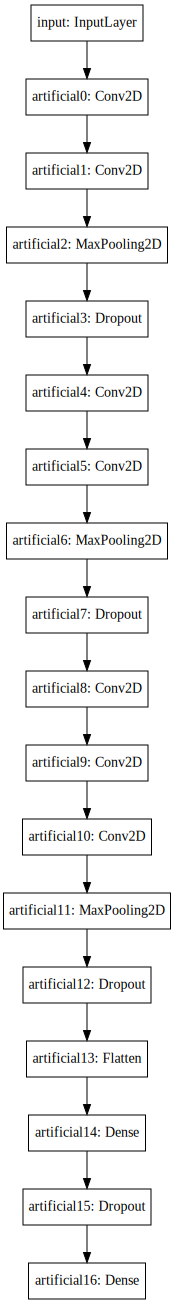

In [224]:
# display artificial expert model diagram
plot_model(artificialModel, to_file='artificialModel.png')
SVG(model_to_dot(artificialModel).create(prog='dot', format='svg'))

![artificialModel.png](./artificialModel.png)

In [95]:
# compile
artificialModel.compile(loss='categorical_crossentropy',
                        optimizer=Adam(),
                        metrics=['accuracy'])

In [96]:
# make saving directory for check point
artSaveDir = "./artCifar10/"
if not os.path.isdir(artSaveDir):
    os.makedirs(artSaveDir)
    
# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = os.path.join(artSaveDir, 'Cifar10_.{epoch:02d}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# load the newest model data if exists
artificialModel = getNewestModel(artificialModel, artSaveDir)

In [97]:
# train
artificialModel.fit(x_trainArt, y_trainArt,
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_testArt, y_testArt),
               callbacks=[es_cb,cp_cb])

Train on 20000 samples, validate on 4000 samples
Epoch 1/100
20000/20000 [==============================] - 12s 615us/step - loss: 1.1387 - acc: 0.4795 - val_loss: 0.7848 - val_acc: 0.6722
Epoch 2/100
20000/20000 [==============================] - 12s 576us/step - loss: 0.7103 - acc: 0.7185 - val_loss: 0.5026 - val_acc: 0.8035
Epoch 3/100
20000/20000 [==============================] - 12s 577us/step - loss: 0.5253 - acc: 0.8013 - val_loss: 0.4196 - val_acc: 0.8432
Epoch 4/100
20000/20000 [==============================] - 12s 576us/step - loss: 0.4292 - acc: 0.8410 - val_loss: 0.4212 - val_acc: 0.8430
Epoch 5/100
20000/20000 [==============================] - 12s 579us/step - loss: 0.3652 - acc: 0.8642 - val_loss: 0.3503 - val_acc: 0.8742
Epoch 6/100
20000/20000 [==============================] - 12s 582us/step - loss: 0.3249 - acc: 0.8808 - val_loss: 0.3194 - val_acc: 0.8850
Epoch 7/100
20000/20000 [==============================] - 12s 581us/step - loss: 0.2908 - acc: 0.8952 - val_lo

In [100]:
# evaluate
artificialModel = getNewestModel(artificialModel, artSaveDir)
artScore = artificialModel.evaluate(x_testArt, y_testArt)
print(artScore)

4000/4000 [==============================] - 1s 200us/step
[0.31449732363224031, 0.88924999999999998]


### Natural expert network

In [101]:
# for natural dataset
x_trainNat = x_train[natureTrain]
x_testNat = x_test[natureTest]
y_trainNat = y_train[natureTrain]
y_testNat = y_test[natureTest]

In [102]:
# get natural dataset
y_trainNat = keras.utils.to_categorical(y_trainNat, orig_classes)
y_testNat = keras.utils.to_categorical(y_testNat, orig_classes)

print("y train nature:{0}\ny test nature:{1}".format(y_trainNat.shape, y_testNat.shape))

y train nature:(30000, 10)
y test nature:(6000, 10)


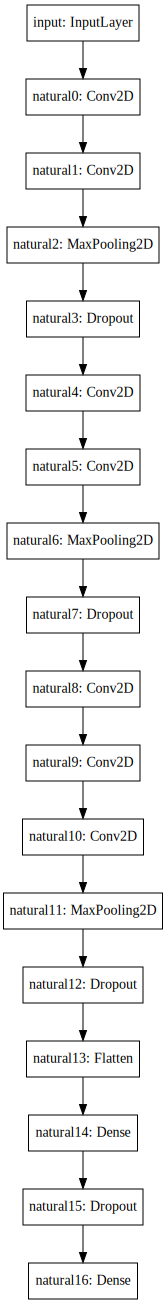

In [225]:
# display natural expert model diagram
plot_model(naturalModel, to_file='naturalModel.png')
SVG(model_to_dot(naturalModel).create(prog='dot', format='svg'))

![naturalModel.png](./naturalModel.png)

In [104]:
# compile
naturalModel.compile(loss='categorical_crossentropy',
                   optimizer=Adam(),
                   metrics=['accuracy'])

In [105]:
# make saving directory for check point
natSaveDir = "./natureCifar10/"
if not os.path.isdir(natSaveDir):
    os.makedirs(natSaveDir)
    
# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = os.path.join(natSaveDir, 'Cifar10_.{epoch:02d}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# load the newest model data if exists
naturalModel = getNewestModel(naturalModel, natSaveDir)

In [106]:
# train
naturalModel.fit(x_trainNat, y_trainNat,
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(x_testNat, y_testNat),
               callbacks=[es_cb,cp_cb])

Train on 30000 samples, validate on 6000 samples
Epoch 1/100
30000/30000 [==============================] - 19s 618us/step - loss: 1.6788 - acc: 0.2835 - val_loss: 1.4030 - val_acc: 0.4502
Epoch 2/100
30000/30000 [==============================] - 17s 581us/step - loss: 1.3118 - acc: 0.4837 - val_loss: 1.1853 - val_acc: 0.5393
Epoch 3/100
30000/30000 [==============================] - 17s 578us/step - loss: 1.1192 - acc: 0.5713 - val_loss: 1.0446 - val_acc: 0.6013
Epoch 4/100
30000/30000 [==============================] - 17s 582us/step - loss: 0.9914 - acc: 0.6251 - val_loss: 0.9170 - val_acc: 0.6562
Epoch 5/100
30000/30000 [==============================] - 17s 582us/step - loss: 0.9037 - acc: 0.6614 - val_loss: 0.8329 - val_acc: 0.6908
Epoch 6/100
30000/30000 [==============================] - 17s 583us/step - loss: 0.8318 - acc: 0.6942 - val_loss: 0.8114 - val_acc: 0.7117
Epoch 7/100
30000/30000 [==============================] - 17s 579us/step - loss: 0.7813 - acc: 0.7129 - val_lo

In [107]:
# evaluate
naturalModel = getNewestModel(naturalModel, natSaveDir)
natScore = naturalModel.evaluate(x_testNat, y_testNat)
print(natScore)

6000/6000 [==============================] - 1s 204us/step
[0.69010207668940227, 0.75466666666666671]


### Make layers in the base VGG, the first gating network, the artificial expert and the natural expert untrainable
<br>
These networks work as feed-forward in the mixture of experts model.

In [108]:
for l in baseModel.layers:
    l.trainable = False
for l in gate0Model.layers:
    l.trainable = False
for l in artificialModel.layers:
    l.trainable = False
for l in naturalModel.layers:
    l.trainable = False

## Connecting the overall networks to form the mixture of experts model

In [109]:
# define sub-Gate network, for the second gating network layer
def subGate(cifarInput, orig_classes, numExperts, name="subGate"):
    name = [name+str(i) for i in range(5)]
    subgate = Flatten(name=name[0])(cifarInput)
    subgate = Dense(512, activation='relu', name=name[1])(subgate)
    subgate = Dropout(0.5, name=name[2])(subgate)
    subgate = Dense(orig_classes*numExperts, activation='softmax', name=name[3])(subgate)
    subgate = Reshape((orig_classes, numExperts), name=name[4])(subgate)
    return subgate

In [110]:
# the artificial gating network
artGate = subGate(cifarInput, orig_classes, 2, "artExpertGate")

# the natural gating network
natureGate = subGate(cifarInput, orig_classes, 2, "natureExpertGate")

In [112]:
# define inference calculation with Keras Lambda layer with base VGG, expert network and the second gating network of corresponding expert as input
# the inference is calculated as sum of multiplications of base VGG inference output and its importance, and expert network inference output and its importance
def subGateLambda(base, expert, subgate):
    output = Lambda(lambda gx: (gx[0]*gx[2][:,:,0]) + (gx[1]*gx[2][:,:,1]), output_shape=(orig_classes,))([base, expert, subgate])
    return output

In [115]:
# connecting the overall networks.
# the Keras backend switch works as deciding with the first gating network, leading to artificial or natural gate
output = Lambda(lambda gx: K.switch(gx[1][:,0] > gx[1][:,1], 
                                    subGateLambda(gx[0], gx[2], gx[4]), 
                                    subGateLambda(gx[0], gx[3], gx[5])), 
                output_shape=(orig_classes,))([baseVGG, gate0VGG, artificialVGG, naturalVGG, artGate, natureGate])

In [116]:
# the mixture of experts model
model = Model(cifarInput, output)

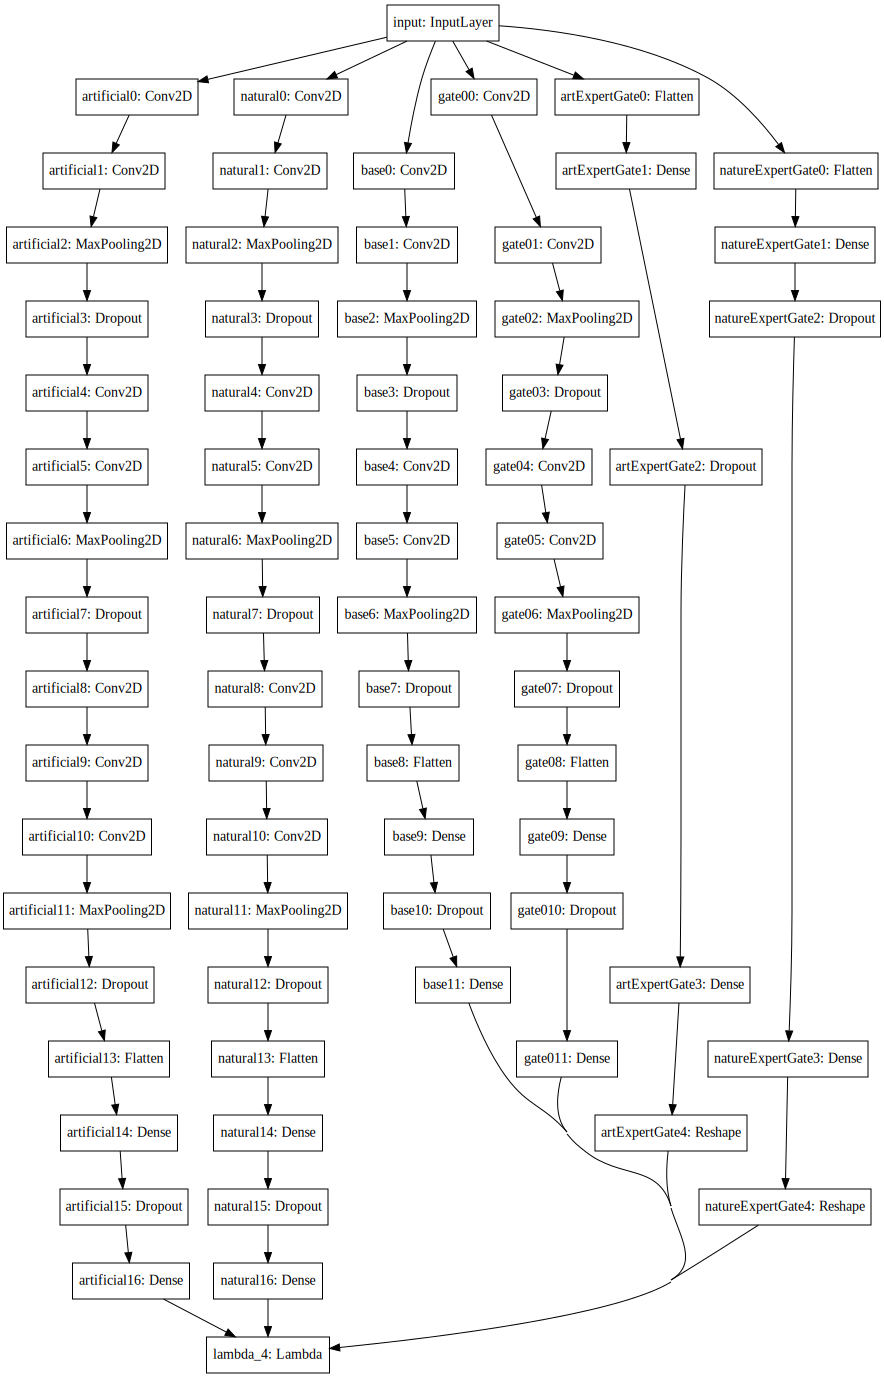

In [226]:
# display the mixture of experts model diagram
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

![model.png](./model.png)

In [118]:
# compile
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [120]:
# show layers and if it's trainable or not
# only the second gating network layers and the last Lambda inference layer are left trainable
for l in model.layers:
    print(l, l.trainable)

<keras.engine.topology.InputLayer object at 0x7f682159f518> False
<keras.layers.convolutional.Conv2D object at 0x7f68147b24a8> False
<keras.layers.convolutional.Conv2D object at 0x7f68146326d8> False
<keras.layers.convolutional.Conv2D object at 0x7f68145e6860> False
<keras.layers.convolutional.Conv2D object at 0x7f68143e5898> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6814595c88> False
<keras.layers.pooling.MaxPooling2D object at 0x7f68143b1860> False
<keras.layers.core.Dropout object at 0x7f68145adc50> False
<keras.layers.core.Dropout object at 0x7f681435dc18> False
<keras.layers.convolutional.Conv2D object at 0x7f68145adef0> False
<keras.layers.convolutional.Conv2D object at 0x7f681435d8d0> False
<keras.layers.convolutional.Conv2D object at 0x7f68148c8390> False
<keras.layers.convolutional.Conv2D object at 0x7f68148c83c8> False
<keras.layers.convolutional.Conv2D object at 0x7f6814556550> False
<keras.layers.convolutional.Conv2D object at 0x7f6814371cc0> False
<keras.layer

In [119]:
# make saving directory for check point
saveDir = "./moe3Cifar10/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)
    
# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = os.path.join(saveDir, 'Cifar10_.{epoch:02d}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# load the newest model data if exists
model = getNewestModel(model, saveDir)

In [121]:
# train
model.fit(x_train, y_train0,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test0),
          callbacks=[es_cb, cp_cb])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 41s 824us/step - loss: 0.4987 - acc: 0.8408 - val_loss: 0.6002 - val_acc: 0.7986
Epoch 2/100
50000/50000 [==============================] - 40s 797us/step - loss: 0.4821 - acc: 0.8489 - val_loss: 0.5965 - val_acc: 0.7979
Epoch 3/100
50000/50000 [==============================] - 40s 804us/step - loss: 0.4772 - acc: 0.8494 - val_loss: 0.5954 - val_acc: 0.7987
Epoch 4/100
50000/50000 [==============================] - 40s 795us/step - loss: 0.4747 - acc: 0.8518 - val_loss: 0.5950 - val_acc: 0.7980
Epoch 5/100
50000/50000 [==============================] - 40s 798us/step - loss: 0.4735 - acc: 0.8520 - val_loss: 0.5948 - val_acc: 0.7980
Epoch 6/100
50000/50000 [==============================] - 40s 795us/step - loss: 0.4763 - acc: 0.8501 - val_loss: 0.5947 - val_acc: 0.7979
Epoch 7/100
50000/50000 [==============================] - 40s 802us/step - loss: 0.4764 - acc: 0.8497 - val_l

In [122]:
# evaluate
score = model.evaluate(x_test, y_test0)
print(score)

10000/10000 [==============================] - 6s 596us/step
[0.59462207956314084, 0.79820000000000002]


## Now the mixture of experts model is made, evaluate if it really takes the appropriate flow

In [123]:
# the first y_test data is labeled 3, so it should be natural object
print(y_test0[0])

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [206]:
# Keras function to get the BaseVGG output
getBase = K.function([model.layers[0].input, K.learning_phase()],
                     [model.layers[63].output])

In [207]:
# Keras function to get the first gating network output
getGate0 = K.function([model.layers[0].input, K.learning_phase()],
                      [model.layers[64].output])

In [208]:
# Keras function to get the artificial expert network output
getArt = K.function([model.layers[0].input, K.learning_phase()],
                       [model.layers[65].output])

In [209]:
# Keras function to get the natural expert network output
getNature = K.function([model.layers[0].input, K.learning_phase()],
                       [model.layers[66].output])

In [210]:
# Keras function to get the output for artificial gating network
getArtGate = K.function([model.layers[0].input, K.learning_phase()],
                        [model.layers[67].output])

In [211]:
# Keras function to get the output for natural gating network
getNatureGate = K.function([model.layers[0].input, K.learning_phase()],
                           [model.layers[68].output])

In [181]:
# output from the first gating network for x_test[0]
# since the second index is higher than the first, it is classified as a natural object
# the first gating should lead the inference to the natural gating network
xtest0Gate = getGate0([[x_test[0]], 0])[0]
xtest0Gate

array([[ 0.00687723,  0.99312276]], dtype=float32)

In [186]:
# output from natural gating network
# the list of softmax output for the importances of base VGG and natural expert network
xtest0NatureGate = getNatureGate([[x_test[0]], 0])[0]
xtest0NatureGate

array([[[ 0.08541576,  0.03585474],
        [ 0.08810793,  0.03100363],
        [ 0.01911297,  0.03751711],
        [ 0.04628449,  0.04165833],
        [ 0.02868748,  0.06180721],
        [ 0.04721113,  0.07710078],
        [ 0.02533226,  0.0840624 ],
        [ 0.04218154,  0.05244576],
        [ 0.08518016,  0.02692058],
        [ 0.07291996,  0.01119581]]], dtype=float32)

In [212]:
# inferenct from base VGG for x_test[0]
xtest0Base = getBase([[x_test[0]], 0])[0]
xtest0Base

array([[  1.30025754e-02,   4.88831941e-03,   6.07487699e-03,
          6.73251569e-01,   3.08401213e-04,   2.47065753e-01,
          2.06855088e-02,   2.67533562e-03,   2.77825613e-02,
          4.26515006e-03]], dtype=float32)

In [199]:
# inference from natural expert network for x_test[0]
xtest0Nature = getNature([[x_test[0]], 0])[0]
xtest0Nature

array([[  2.08449508e-11,   4.72127615e-11,   1.22241955e-02,
          6.25748694e-01,   7.82116503e-03,   3.36175740e-01,
          6.49287738e-03,   1.15373293e-02,   2.38116731e-11,
          2.11326633e-11]], dtype=float32)

In [219]:
# multiply the base VGG inference with the natural gating inference for the importance of base VGG
# multiply the natural expert inference with the natural gating inference for the importance of natural expert
# get the sum
(xtest0Base * xtest0NatureGate[:,:,0]) + (xtest0Nature * xtest0NatureGate[:,:,1])

array([[ 0.00111062,  0.0004307 ,  0.00057473,  0.05722876,  0.00049225,
         0.03758366,  0.00106982,  0.00071793,  0.00236652,  0.00031101]], dtype=float32)

In [194]:
# the mixture of experts prediction for x_test[0]
# showing exactly the same inferences!
model.predict(x_test[:1])

array([[ 0.00111062,  0.0004307 ,  0.00057473,  0.05722876,  0.00049225,
         0.03758366,  0.00106982,  0.00071793,  0.00236652,  0.00031101]], dtype=float32)

![5.png](./5.png)